--- Generating Graph Series ---
Sizes: [20, 30, 40, 50]
Connectivity: 0.25, Busy Node Interval: 5

Creating graph size: 20 (seed=62)...
  Graph created (Connected): 20 nodes, 44 edges.

Creating graph size: 30 (seed=72)...
  Graph created (Connected): 30 nodes, 106 edges.

Creating graph size: 40 (seed=82)...
  Graph created (Connected): 40 nodes, 199 edges.

Creating graph size: 50 (seed=92)...
  Graph created (Connected): 50 nodes, 300 edges.

--- Graph Generation Complete ---

--- Starting Training & Benchmarking Across Sizes ---

=============== Processing Graph Size: 20 ===============
Initializing DQN agent for size 20...
Training DQN for 20000 episodes...

--- Starting DQN Training (Size: 20, Episodes: 20000) ---
  Ep 1000/20000 | Avg R(100): 43.75 | Avg S(100): 4.8 | Avg Loss(100): 5.0150 | LoopsP: 1.34 | MaxSP: 0.02 | Eps: 0.404
  Ep 2000/20000 | Avg R(100): 46.58 | Avg S(100): 3.5 | Avg Loss(100): 2.3753 | LoopsP: 0.60 | MaxSP: 0.00 | Eps: 0.276
  Ep 3000/20000 | Avg R(100): 

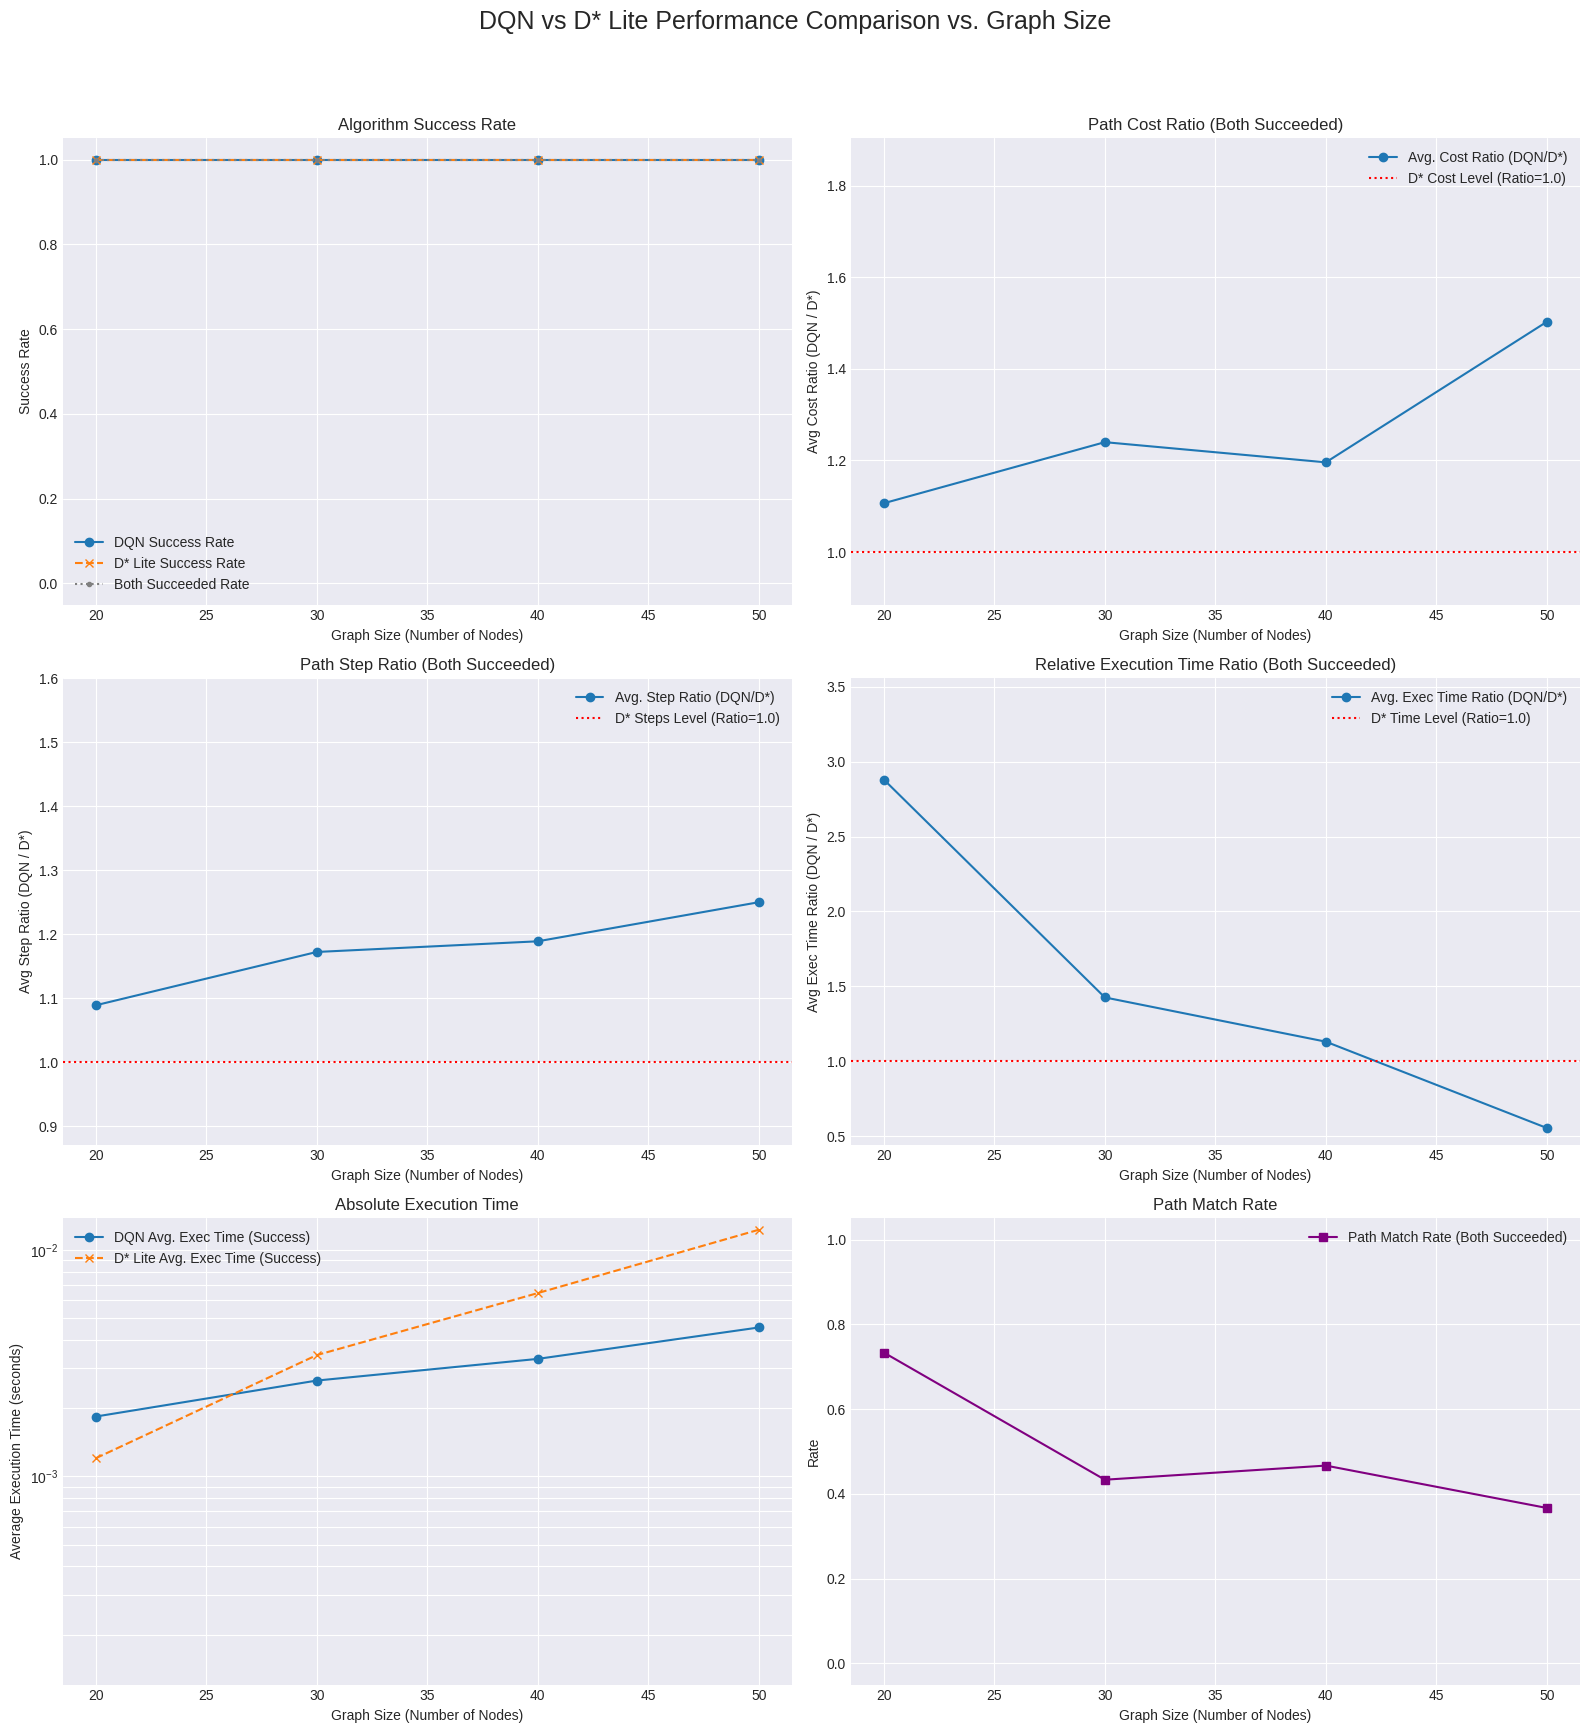


Benchmark summaries saved to benchmark_results_dqn_vs_dstar_binary_adj.json

--- Experiment Finished ---


In [1]:
# --- Imports ---
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import time
import heapq
from collections import defaultdict, deque, namedtuple
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import copy # Needed for deep copying graph states
import json # For potentially saving detailed results later

# --- Graph Creation (Using the version from the DQN script) ---
def create_dynamic_graph(num_nodes=20, seed=42, connectivity=0.3,
                         busy_node_pattern_interval=5):
    """
    Creates a deterministic random graph with time-varying edge weights,
    assigns node positions, and selects busy nodes based on a consistent
    index interval pattern to ensure scalable distribution.
    Matches the style of the Q-Learning version for consistency.
    """
    if num_nodes <= 0:
        print("Warning: num_nodes must be positive. Returning empty graph.")
        return nx.Graph(), {} # Return empty graph and positions

    # Set seeds for reproducibility FOR THIS SPECIFIC GRAPH SIZE
    random.seed(seed)
    np.random.seed(seed)

    # Create a random graph (undirected)
    G = nx.erdos_renyi_graph(n=num_nodes, p=connectivity, seed=seed)

    # --- Ensure Connectivity ---
    max_attempts = num_nodes * 2
    attempts = 0
    # Only try to connect if there's more than one node
    if G.number_of_nodes() > 1:
        while not nx.is_connected(G) and attempts < max_attempts :
            components = list(nx.connected_components(G))
            if len(components) > 1:
                largest_component = max(components, key=len)
                other_components = [c for c in components if c != largest_component]
                if not other_components: break
                comp_to_connect = random.choice(other_components)

                u = random.choice(list(largest_component))
                v = random.choice(list(comp_to_connect))
                G.add_edge(u, v)
            else: break
            attempts += 1

        if attempts >= max_attempts and not nx.is_connected(G):
             print(f"Warning: Could not ensure graph connectivity for size {num_nodes} after {max_attempts} attempts.")

    # --- Define busy nodes using the scalable index pattern ---
    busy_nodes = []
    if num_nodes > 0 and busy_node_pattern_interval > 0:
        busy_nodes = [i for i in range(num_nodes) if i % busy_node_pattern_interval == 0]
    elif num_nodes > 0:
        print(f"Warning: Invalid busy_node_pattern_interval ({busy_node_pattern_interval}). No busy nodes selected.")

    # --- Assign initial edge weights and dynamic parameters ---
    for u, v in G.edges():
        is_busy_edge = (u in busy_nodes) or (v in busy_nodes)
        base_weight = random.uniform(7.0, 10.0) if is_busy_edge else random.uniform(1.0, 4.0)

        G[u][v]['weight'] = base_weight
        G[u][v]['base_weight'] = base_weight
        G[u][v]['variation'] = random.uniform(0.5, 2.5) # Consistent dynamic range
        G[u][v]['period'] = random.uniform(0.05, 0.3)   # Consistent dynamic speed

    # --- Assign node positions ---
    pos = {} # Initialize positions dict
    try:
        if G.number_of_nodes() > 50:
            pos = nx.kamada_kawai_layout(G)
        elif G.number_of_nodes() > 0:
            pos = nx.spring_layout(G, seed=seed)
    except Exception as e:
         print(f"Warning: Layout algorithm failed for size {num_nodes} (seed={seed}, error={e}). Using random layout.")
         if G.nodes: pos = nx.random_layout(G, seed=seed)

    # Assign positions to graph attribute IF positions were calculated
    if pos:
        G.pos = pos
    elif G.number_of_nodes() > 0: # Fallback if pos is still empty
         print("Fallback to random layout.")
         G.pos = nx.random_layout(G, seed=seed)
    else:
         G.pos = {} # Ensure attribute exists even for empty graph

    return G

# --- Graph Utilities (Unaffected) ---
def update_edge_weights(G, time_step):
    """Updates edge weights based on time step."""
    if not G or not G.edges: return G
    for u, v in G.edges():
        base = G[u][v].get('base_weight', 5.0)
        variation = G[u][v].get('variation', 1.0)
        period = G[u][v].get('period', 0.2)
        try:
            factor = np.sin(time_step * period) * variation
            G[u][v]['weight'] = max(0.1, base + factor)
        except Exception: G[u][v]['weight'] = base # Fallback on error
    return G

def reset_graph_weights(G):
    """Resets edge weights to base values."""
    if not G or not G.edges: return G
    for u, v in G.edges():
        G[u][v]['weight'] = G[u][v].get('base_weight', random.uniform(1, 10))
    return G

# --- D* Lite Implementation (Unaffected, using version from DQN script) ---
class DStarLite:
    def __init__(self, graph, start, goal):
        self.G = graph
        self.start = start
        self.goal = goal
        self.current = start
        self.U = []  # Priority queue (min-heap)
        self.g = defaultdict(lambda: float('inf'))
        self.rhs = defaultdict(lambda: float('inf'))
        self.km = 0 # Key modifier for replanning
        self.rhs[goal] = 0
        # Error handling for initial push
        try:
             initial_key = self.calculate_key(goal)
             if not isinstance(initial_key, tuple) or len(initial_key) != 2:
                 raise TypeError(f"Initial key for goal {goal} is not a valid tuple: {initial_key}")
             heapq.heappush(self.U, (initial_key, goal))
        except (TypeError, AttributeError) as e:
            print(f"Error pushing initial goal node {goal} to heap: {e}")
            try: print(f"Goal key calculation resulted in: {self.calculate_key(goal)}")
            except Exception: print("Further error calculating key for debugging.")
            raise e

    def calculate_key(self, node):
        g_val = self.g[node]
        rhs_val = self.rhs[node]
        min_g_rhs = min(g_val, rhs_val)
        h_cost = self.heuristic(self.start, node)
        if not isinstance(h_cost, (int, float)): h_cost = 0 # Ensure numeric heuristic
        return (min_g_rhs + h_cost + self.km, min_g_rhs)

    def heuristic(self, a, b):
        if a not in self.G or b not in self.G: return 0
        if not hasattr(self.G, 'pos') or not self.G.pos: return 0
        if a not in self.G.pos or b not in self.G.pos: return 0
        pos_a, pos_b = self.G.pos.get(a), self.G.pos.get(b)
        if (isinstance(pos_a, (list, tuple)) and len(pos_a) >= 2 and
            isinstance(pos_b, (list, tuple)) and len(pos_b) >= 2 and
            all(isinstance(coord, (int, float)) for coord in list(pos_a[:2]) + list(pos_b[:2]))):
            try:
                dist = math.sqrt((pos_a[0] - pos_b[0])**2 + (pos_a[1] - pos_b[1])**2)
                return dist if not math.isnan(dist) else 0.0
            except (TypeError, ValueError): return 0.0
        return 0.0

    def get_edge_cost(self, u, v):
         """Safely get edge cost."""
         if self.G.has_edge(u, v):
             weight = self.G[u][v].get('weight', float('inf'))
             return weight if isinstance(weight, (int, float)) else float('inf')
         return float('inf')

    def update_vertex(self, u):
        if u != self.goal:
            min_rhs = float('inf')
            neighbors = list(self.G.neighbors(u)) # Get neighbors once
            if not neighbors: # Handle node with no neighbors
                 self.rhs[u] = float('inf')
            else:
                for v in neighbors:
                     cost = self.get_edge_cost(u, v)
                     if cost != float('inf') and self.g[v] != float('inf'):
                         min_rhs = min(min_rhs, cost + self.g[v])
                self.rhs[u] = min_rhs if min_rhs != float('inf') else float('inf') # Ensure it stays inf if no valid path found

        u_index = -1
        for i, (_, node) in enumerate(self.U):
             if node == u:
                 u_index = i
                 break
        if u_index != -1:
            self.U.pop(u_index)
            heapq.heapify(self.U)

        if self.g[u] != self.rhs[u]:
            try:
                 key_u = self.calculate_key(u)
                 if not isinstance(key_u, tuple) or len(key_u) != 2: raise TypeError(f"Invalid key: {key_u}")
                 heapq.heappush(self.U, (key_u, u))
            except TypeError as e:
                 print(f"Error pushing node {u} during update: {e}, Key: {self.calculate_key(u)}")

    def compute_shortest_path(self):
        max_compute_steps = self.G.number_of_nodes() * self.G.number_of_edges() * 2 # Generous limit
        if max_compute_steps == 0: max_compute_steps = 1000 # Prevent infinite loop if graph is tiny/empty
        compute_steps = 0
        start_key_condition = self.calculate_key(self.start)

        while self.U and (not self.U or self.U[0][0] < start_key_condition or self.rhs[self.start] != self.g[self.start]):
            compute_steps += 1
            if compute_steps > max_compute_steps:
                 # print(f"Warning: Exceeded D* compute step limit ({max_compute_steps}).") # Less verbose
                 break

            try:
                k_old, u = heapq.heappop(self.U)
            except IndexError:
                # print("Warning: D* heap became empty during compute_shortest_path.") # Less verbose
                break # Heap is empty, stop

            k_new = self.calculate_key(u)

            if k_old < k_new:
                try: heapq.heappush(self.U, (k_new, u))
                except TypeError as e: print(f"Error pushing {u} (key increased): {e}")
            elif self.g[u] > self.rhs[u]:
                self.g[u] = self.rhs[u]
                for s in self.G.neighbors(u):
                    self.update_vertex(s)
            else:
                g_old = self.g[u] # Store old g value
                self.g[u] = float('inf')
                affected_nodes = list(self.G.neighbors(u)) + [u]
                for s in affected_nodes:
                    self.update_vertex(s)

            start_key_condition = self.calculate_key(self.start)

            # Optional: Check queue size limit
            # if len(self.U) > self.G.number_of_nodes() * 10: # More generous warning limit
            #     print(f"Warning: D* queue size potentially excessive ({len(self.U)} nodes={self.G.number_of_nodes()}).")

    def get_next_node(self):
        if self.current == self.goal:
            return None # Already at the goal

        min_cost_plus_g = float('inf')
        next_node = None
        neighbors = list(self.G.neighbors(self.current))

        if not neighbors: # Check if current node has any neighbors
             return None

        for neighbor in neighbors:
            cost = self.get_edge_cost(self.current, neighbor)
            g_neighbor = self.g[neighbor]
            if cost == float('inf') or g_neighbor == float('inf'): continue

            current_cost_plus_g = cost + g_neighbor

            if current_cost_plus_g < min_cost_plus_g:
                min_cost_plus_g = current_cost_plus_g
                next_node = neighbor
            elif current_cost_plus_g == min_cost_plus_g and next_node is not None:
                 h_neighbor = self.heuristic(neighbor, self.goal)
                 h_current_best = self.heuristic(next_node, self.goal)
                 if h_neighbor < h_current_best:
                     next_node = neighbor
                 elif h_neighbor == h_current_best and neighbor < next_node: # Use node index as final tie-breaker
                     next_node = neighbor
        return next_node

    def move_to(self, node):
        if node is not None and node != self.current:
             self.current = node
             self.start = node # Crucial: update the 'start' for future heuristic/key calculations

    def notify_edge_changes(self, changed_edges):
        nodes_to_update = set()
        for u, v in changed_edges:
            if self.G.has_edge(u, v):
                nodes_to_update.add(u)
                nodes_to_update.add(v)
        for node in nodes_to_update:
            self.update_vertex(node)
        try:
             self.compute_shortest_path()
        except Exception as e:
             print(f"Error during D* compute_shortest_path after edge changes: {e}")

# --- D* Lite Navigation Function (Unaffected, using version from DQN script) ---
def navigate_with_dstar(graph_instance, start_node, goal_node, max_steps=None):
    """
    Navigate from start to goal in a dynamic graph using D* Lite.
    Returns path, total_cost, steps_taken, execution_time.
    (Version adapted for benchmarking framework)
    """
    G_nav = graph_instance # Use the provided instance directly
    if start_node not in G_nav or goal_node not in G_nav:
        print(f"D* Error: Start {start_node} or Goal {goal_node} not in graph (Size: {G_nav.number_of_nodes()}).")
        return [], float('inf'), 0, 0.0 # Path, cost, steps, time

    reset_graph_weights(G_nav) # Ensure starting from base weights for fair comparison
    if not hasattr(G_nav, 'pos'):
        print(f"D* Warning: Graph instance for size {G_nav.number_of_nodes()} missing 'pos' attribute. Using 0 heuristic.")

    try:
        planner = DStarLite(G_nav, start_node, goal_node)
    except Exception as e:
        print(f"Error initializing D* for {start_node}->{goal_node} (Size: {G_nav.number_of_nodes()}): {e}")
        return [], float('inf'), 0, 0.0

    current_node = start_node
    steps_taken = 0
    total_cost = 0.0
    path = [current_node]
    if max_steps is None: max_steps = G_nav.number_of_nodes() * 3

    start_time_exec = time.perf_counter() # Start timing D* execution

    try:
         planner.compute_shortest_path()
    except Exception as e:
         print(f"Error during initial D* compute for {start_node}->{goal_node}: {e}")
         end_time_exec = time.perf_counter()
         return [], float('inf'), 0, end_time_exec - start_time_exec

    if planner.g[start_node] == float('inf'):
        end_time_exec = time.perf_counter()
        return [], float('inf'), 0, end_time_exec - start_time_exec

    # Navigation loop
    while current_node != goal_node and steps_taken < max_steps:
        next_node = planner.get_next_node()
        if next_node is None:
            total_cost = float('inf'); break

        edge_cost = planner.get_edge_cost(current_node, next_node)
        if edge_cost == float('inf'):
             print(f"D* Error: Planned edge ({current_node},{next_node}) has infinite cost at step {steps_taken}!")
             total_cost = float('inf'); break

        total_cost += edge_cost
        planner.move_to(next_node)
        current_node = next_node
        path.append(current_node)
        steps_taken += 1

        if current_node == goal_node: break

        try:
             update_edge_weights(G_nav, steps_taken)
        except Exception as e:
             print(f"Error updating edge weights at step {steps_taken}: {e}")
             total_cost = float('inf'); break

        changed_edges = list(G_nav.edges())
        try:
             planner.notify_edge_changes(changed_edges) # Replan happens inside notify
        except Exception as e:
             print(f"Error during D* notify/recompute at step {steps_taken} for {start_node}->{goal_node}: {e}")
             total_cost = float('inf'); break

    end_time_exec = time.perf_counter() # Stop timing D* execution
    elapsed_time = end_time_exec - start_time_exec
    success = (current_node == goal_node and total_cost != float('inf'))
    return path if success else [], total_cost if success else float('inf'), steps_taken, elapsed_time

# --- DQN Implementation (MODIFIED STATE REPRESENTATION) ---

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        actual_batch_size = min(batch_size, len(self.memory))
        if actual_batch_size == 0: return []
        return random.sample(self.memory, actual_batch_size)

    def __len__(self):
        return len(self.memory)

class QNetwork(nn.Module):
    def __init__(self, n_nodes, hidden_dim=128):
        super(QNetwork, self).__init__()
        # MODIFIED: Input dim reflects [current_one_hot, goal_one_hot, adjacency_vector_BINARY]
        input_dim = n_nodes * 3
        output_dim = n_nodes    # Q-value for each possible next node
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, output_dim)
        # print(f"Initialized QNetwork with input_dim={input_dim}, output_dim={output_dim}")

    def forward(self, state):
        if not isinstance(state, torch.Tensor):
             print(f"Warning: Input to QNetwork forward is not a Tensor (type: {type(state)}).")
             # Simplified error handling: Raise immediately
             raise TypeError("QNetwork input must be a Tensor")

        if state.dtype != torch.float32:
            state = state.float()

        x = F.relu(self.layer1(state))
        x = F.relu(self.layer2(x))
        q_values = self.layer3(x)
        return q_values

class DQNAgent:
    def __init__(self, graph, learning_rate=1e-4, discount_factor=0.9,
                 exploration_rate=1.0, exploration_decay=0.999, min_exploration_rate=0.05,
                 memory_capacity=10000, batch_size=128, target_update_freq=10,
                 loop_penalty=2.0,
                 max_steps_penalty=5.0,
                 reward_edge_scale=10.0 # Renamed for clarity, used for reward scaling
                 ):
        self.G = graph
        try:
            self.nodes = sorted(list(graph.nodes()))
        except TypeError:
            print("Warning: Graph nodes may not be directly sortable. Converting to strings for sorting.")
            self.nodes = sorted(list(graph.nodes()), key=str)

        self.num_nodes = len(self.nodes)
        if self.num_nodes == 0:
             raise ValueError("Cannot initialize DQNAgent with an empty graph.")

        self.node_to_index = {node: i for i, node in enumerate(self.nodes)}
        self.index_to_node = {i: node for i, node in enumerate(self.nodes)}

        self.gamma = discount_factor
        self.start_epsilon = exploration_rate
        self.epsilon = exploration_rate
        self.epsilon_decay_rate = exploration_decay # Rate for exponential decay calculation
        self.min_epsilon = min_exploration_rate
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq # In terms of episodes
        self.loop_penalty_val = loop_penalty
        self.max_steps_penalty_val = max_steps_penalty
        self.reward_edge_scale = reward_edge_scale # Store scaling factor for reward calculation

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.policy_net = QNetwork(self.num_nodes).to(self.device)
        self.target_net = QNetwork(self.num_nodes).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=learning_rate, amsgrad=True)
        self.memory = ReplayMemory(memory_capacity)
        self.positions = getattr(self.G, 'pos', None)
        self.steps_done = 0 # Counter for total steps across training (for epsilon decay)
        self.episode_count = 0 # Counter for episodes (for target net update)

    # --- STATE REPRESENTATION MODIFIED ---
    def _get_enhanced_state_tensor(self, current_node, goal_node, graph_state):
        """
        Converts state (current_node, goal_node, graph_state) to tensor.
        State: [current_one_hot (N), goal_one_hot (N), binary_adjacency_vector (N)]
        Adjacency vector is 1 if a node is a neighbor of current_node, 0 otherwise.
        """
        if graph_state is None or not isinstance(graph_state, nx.Graph):
             print(f"Error: Invalid graph_state received in _get_enhanced_state_tensor (type: {type(graph_state)})")
             return None

        if current_node not in self.node_to_index or goal_node not in self.node_to_index:
             print(f"Error: current_node ({current_node}) or goal_node ({goal_node}) not found in node_to_index map.")
             return None

        try:
            current_idx = self.node_to_index[current_node]
            goal_idx = self.node_to_index[goal_node]
            current_one_hot = F.one_hot(torch.tensor([current_idx]), num_classes=self.num_nodes).to(self.device).float()
            goal_one_hot = F.one_hot(torch.tensor([goal_idx]), num_classes=self.num_nodes).to(self.device).float()

            # *** MODIFIED: Create BINARY adjacency vector ***
            adjacency_vector = torch.zeros(self.num_nodes, device=self.device, dtype=torch.float)
            if current_node in graph_state: # Check if current_node exists in graph_state
                 neighbors = list(graph_state.neighbors(current_node))
                 for neighbor_node in neighbors:
                     if neighbor_node in self.node_to_index: # Ensure neighbor is mappable
                         neighbor_idx = self.node_to_index[neighbor_node]
                         adjacency_vector[neighbor_idx] = 1.0 # Set to 1 if neighbor

            # Concatenate: [current (N), goal (N), adjacency (N)] -> Shape [1, 3N]
            state_tensor = torch.cat((current_one_hot, goal_one_hot, adjacency_vector.unsqueeze(0)), dim=1)
            return state_tensor

        except KeyError as e:
            print(f"Error creating state tensor: Node key not found - {e}. current={current_node}, goal={goal_node}, nodes={self.nodes}")
            return None
        except Exception as e:
            print(f"Unexpected error creating state tensor: {e}")
            return None

    def choose_action(self, state_tensor, current_node, graph_state, is_training=True):
        """Choose action using epsilon-greedy, considering only valid neighbors."""
        if state_tensor is None:
             print(f"Error: choose_action received None state_tensor for node {current_node}.")
             return None, None

        try:
            available_neighbors = list(graph_state.neighbors(current_node))
        except nx.NetworkXError:
            print(f"Error: Node {current_node} not found in graph_state during choose_action.")
            return None, None

        if not available_neighbors:
            return None, None # Agent is stuck

        # Calculate current epsilon using exponential decay based on steps_done
        # Adjusted decay denominator: num_nodes * 500 (adjust as needed)
        decay_factor = self.num_nodes * 500
        current_epsilon = self.min_epsilon + (self.start_epsilon - self.min_epsilon) * \
            math.exp(-1. * float(self.steps_done) / max(1, decay_factor)) # Avoid division by zero
        current_epsilon = max(self.min_epsilon, current_epsilon) # Clamp at minimum

        sample = random.random()

        if is_training and sample < current_epsilon:
            # Explore: choose a random valid neighbor
            try:
                valid_neighbors_with_indices = [n for n in available_neighbors if n in self.node_to_index]
                if not valid_neighbors_with_indices:
                     print(f"Error: No valid neighbors with indices found for node {current_node}")
                     return None, None
                action_node = random.choice(valid_neighbors_with_indices)
                action_index = self.node_to_index[action_node]
                return action_node, action_index
            except KeyError:
                 # This block should ideally not be reached if the list comprehension is correct
                 print(f"Error: Randomly chosen neighbor {action_node} not in node_to_index map (unexpected).")
                 return None, None

        else:
            # Exploit: choose the best valid action from the policy network
            with torch.no_grad():
                self.policy_net.eval()
                try:
                    q_values = self.policy_net(state_tensor) # Shape [1, num_nodes]
                except Exception as e:
                     print(f"Error during policy_net forward pass in choose_action: {e}")
                     if is_training: self.policy_net.train()
                     return None, None
                if is_training: self.policy_net.train() # Switch back promptly

                # Mask invalid actions (non-neighbors or nodes not in map)
                mask = torch.full(q_values.shape, -float('inf'), device=self.device)
                neighbor_indices = []
                for n in available_neighbors:
                    if n in self.node_to_index:
                        neighbor_indices.append(self.node_to_index[n])

                if not neighbor_indices:
                    print(f"Warning: No valid neighbor indices found for node {current_node} during exploitation.")
                    return None, None # Cannot choose if no valid neighbors

                mask[0, neighbor_indices] = 0.0 # Allow valid neighbors
                masked_q_values = q_values + mask
                best_action_index = masked_q_values.argmax(dim=1).item()

                try:
                    best_action_node = self.index_to_node[best_action_index]
                except KeyError:
                     print(f"CRITICAL ERROR: best_action_index {best_action_index} not found in index_to_node map.")
                     return None, None

                # Sanity check
                if best_action_node not in available_neighbors:
                    print(f"CRITICAL WARNING: Best action {best_action_node} (idx {best_action_index}) is not in available neighbors {available_neighbors} for node {current_node}! Falling back.")
                    valid_neighbors_with_indices = [n for n in available_neighbors if n in self.node_to_index]
                    if not valid_neighbors_with_indices: return None, None
                    action_node = random.choice(valid_neighbors_with_indices)
                    action_index = self.node_to_index[action_node]
                    return action_node, action_index

                return best_action_node, best_action_index

    def calculate_reward(self, current_node, next_node, goal_node, graph_state, path_history):
        """Calculate reward including penalties for loops and excessive steps."""
        # --- Base Reward Calculation ---
        if not graph_state.has_edge(current_node, next_node):
            return -20.0 # Large penalty for invalid move attempt

        # Use the stored reward scaling factor
        scale_factor = max(1e-6, self.reward_edge_scale)
        default_high_cost = 10.0 * scale_factor # Use default high cost scaled appropriately

        edge_weight = graph_state[current_node][next_node].get('weight', default_high_cost)
        if not isinstance(edge_weight, (int, float)) or math.isnan(edge_weight):
             edge_weight = default_high_cost # Ensure numeric

        # Reward is negative of scaled cost
        reward = -float(edge_weight) / scale_factor

        # --- Goal Bonus ---
        if next_node == goal_node:
            reward += 50.0 # Significant bonus for reaching goal

        # --- Penalty Application ---
        # 1. Loop Penalty
        if next_node in path_history:
            visit_count = path_history.count(next_node)
            reward -= self.loop_penalty_val * visit_count

        # 2. Max Steps Penalty
        max_steps_threshold = self.num_nodes * 1.5 # Threshold relative to size
        current_path_length = len(path_history)
        if current_path_length > max_steps_threshold:
            reward -= self.max_steps_penalty_val

        # Optional: Small cost per step
        reward -= 0.05

        return reward

    def _optimize_model(self):
        """Performs one step of optimization on the policy network."""
        if len(self.memory) < self.batch_size:
            return None # Not enough samples yet

        transitions = self.memory.sample(self.batch_size)
        if not transitions: return None
        batch = Transition(*zip(*transitions))

        # Filter out None states and ensure tensors are valid
        valid_indices = [i for i, s in enumerate(batch.state) if isinstance(s, torch.Tensor)]
        if not valid_indices: return None

        try:
             state_batch = torch.cat([batch.state[i] for i in valid_indices]).to(self.device)
             action_batch = torch.tensor([batch.action[i] for i in valid_indices], dtype=torch.long, device=self.device).unsqueeze(1)
             reward_batch = torch.cat([batch.reward[i] for i in valid_indices]).to(self.device).unsqueeze(1)
             done_batch = torch.cat([batch.done[i] for i in valid_indices]).to(self.device).float().unsqueeze(1)

             non_final_mask_list = [isinstance(batch.next_state[i], torch.Tensor) for i in valid_indices]
             non_final_mask = torch.tensor(non_final_mask_list, device=self.device, dtype=torch.bool)
             non_final_next_states_list = [batch.next_state[i] for i in valid_indices if isinstance(batch.next_state[i], torch.Tensor)]

        except (RuntimeError, TypeError, IndexError) as e:
            print(f"Error preparing batch tensors: {e}")
            return None

        # Compute Q(s_t, a)
        self.policy_net.train()
        try:
             state_action_values = self.policy_net(state_batch).gather(1, action_batch)
        except Exception as e:
             print(f"Error during policy_net forward pass in optimize_model: {e}")
             return None

        # Compute V(s_{t+1}) for all next states
        next_state_values = torch.zeros(len(valid_indices), device=self.device).unsqueeze(1)
        if non_final_next_states_list:
             try:
                 non_final_next_states = torch.cat(non_final_next_states_list).to(self.device)
                 self.target_net.eval()
                 with torch.no_grad():
                     max_q_values_next = self.target_net(non_final_next_states).max(1)[0]
                 next_state_values[non_final_mask] = max_q_values_next.unsqueeze(1)
             except Exception as e:
                 print(f"Error calculating next state values: {e}")
                 next_state_values[non_final_mask] = 0.0 # Fallback

        # Compute the expected Q values
        expected_state_action_values = reward_batch + (self.gamma * next_state_values * (1.0 - done_batch))

        # Compute Loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()

        return loss.item()

    def train(self, num_episodes=5000, max_steps_per_episode=100):
        """Train the DQN agent with penalties."""
        print(f"\n--- Starting DQN Training (Size: {self.num_nodes}, Episodes: {num_episodes}) ---")
        training_stats = {'episode_rewards': [], 'episode_steps': [], 'episode_loss': [], 'loops_penalized': [], 'max_steps_penalized': []}
        nodes_list = list(self.nodes)
        if len(nodes_list) < 2:
            print("Warning: Graph has less than 2 nodes. Training skipped.")
            return training_stats

        start_train_time = time.perf_counter()
        self.steps_done = 0 # Reset step counter for new training session
        self.episode_count = 0 # Reset episode counter

        for ep in range(num_episodes):
            self.episode_count += 1
            # --- Episode Setup ---
            try:
                 start_node, goal_node = random.sample(nodes_list, 2)
            except ValueError:
                 print("Error: Cannot sample 2 distinct nodes. Check graph nodes.")
                 continue # Skip episode

            current_graph_state = self.G.copy() # Use a copy for the episode
            reset_graph_weights(current_graph_state)
            current_node = start_node
            state_tensor = self._get_enhanced_state_tensor(current_node, goal_node, current_graph_state)
            if state_tensor is None:
                 print(f"Error: Failed to get initial state tensor for ep {ep+1}. Skipping episode.")
                 continue

            episode_reward = 0
            episode_loss_sum = 0.0
            valid_loss_steps = 0
            steps_in_episode = 0
            path_history = [current_node]
            episode_loops_penalized = 0
            episode_max_steps_penalized = 0

            # --- Run Episode ---
            for step in range(max_steps_per_episode):
                update_edge_weights(current_graph_state, steps_in_episode)
                action_node, action_index = self.choose_action(state_tensor, current_node, current_graph_state, is_training=True)
                self.steps_done += 1 # Increment global step counter

                if action_node is None or action_index is None:
                    done = True
                    reward = -20.0 # Penalty for getting stuck
                    next_state_tensor = None
                    next_node = None
                else:
                    reward = self.calculate_reward(current_node, action_node, goal_node, current_graph_state, path_history)
                    if action_node in path_history: episode_loops_penalized += 1
                    if len(path_history) > self.num_nodes * 1.5: episode_max_steps_penalized += 1

                    next_node = action_node
                    done = (next_node == goal_node)

                    if done: next_state_tensor = None
                    else: next_state_tensor = self._get_enhanced_state_tensor(next_node, goal_node, current_graph_state)

                    path_history.append(next_node)

                episode_reward += reward
                steps_in_episode += 1
                reward_tensor = torch.tensor([reward], device=self.device, dtype=torch.float)
                done_tensor = torch.tensor([done], device=self.device, dtype=torch.bool)

                if action_index is not None and state_tensor is not None: # Ensure state was valid before action
                     self.memory.push(state_tensor, action_index, next_state_tensor, reward_tensor, done_tensor)

                current_node = next_node
                state_tensor = next_state_tensor # Can be None if done or error

                loss = self._optimize_model()
                if loss is not None:
                    episode_loss_sum += loss
                    valid_loss_steps += 1

                if done or current_node is None or state_tensor is None:
                    break # Goal reached, stuck, or state error

            # --- End of Episode ---
            training_stats['episode_rewards'].append(episode_reward)
            training_stats['episode_steps'].append(steps_in_episode)
            avg_episode_loss = episode_loss_sum / valid_loss_steps if valid_loss_steps > 0 else 0.0
            training_stats['episode_loss'].append(avg_episode_loss)
            training_stats['loops_penalized'].append(episode_loops_penalized)
            training_stats['max_steps_penalized'].append(episode_max_steps_penalized)

            if self.episode_count % self.target_update_freq == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

            if (ep + 1) % (num_episodes // 20 or 100) == 0: # Print more frequently
                 if len(training_stats['episode_rewards']) >= 100:
                      avg_r = np.mean(training_stats['episode_rewards'][-100:])
                      avg_s = np.mean(training_stats['episode_steps'][-100:])
                      avg_l = np.mean([l for l in training_stats['episode_loss'][-100:] if l is not None and not np.isnan(l)])
                      avg_lp = np.mean(training_stats['loops_penalized'][-100:])
                      avg_mp = np.mean(training_stats['max_steps_penalized'][-100:])
                      decay_factor = self.num_nodes * 500 # Match epsilon calculation
                      current_epsilon_log = self.min_epsilon + (self.start_epsilon - self.min_epsilon) * math.exp(-1. * float(self.steps_done) / max(1, decay_factor))
                      current_epsilon_log = max(self.min_epsilon, current_epsilon_log)
                      print(f"  Ep {ep+1}/{num_episodes} | Avg R(100): {avg_r:.2f} | Avg S(100): {avg_s:.1f} | Avg Loss(100): {avg_l:.4f} | LoopsP: {avg_lp:.2f} | MaxSP: {avg_mp:.2f} | Eps: {current_epsilon_log:.3f}")
                 else: print(f"  Ep {ep+1}/{num_episodes}")


        print(f"--- DQN Training Finished in {time.perf_counter() - start_train_time:.2f}s ---")
        return training_stats

    def find_path(self, start_node, goal_node, graph_instance=None, max_steps=None):
        """
        Find the path using the learned DQN policy (evaluation mode).
        Uses provided graph_instance if given, otherwise self.G.
        Returns path, total_cost, steps_taken, execution_time.
        """
        if graph_instance is None: graph_instance = self.G
        else:
             if not hasattr(graph_instance, 'pos') and hasattr(self.G, 'pos'):
                  graph_instance.pos = self.G.pos

        current_graph_state = graph_instance
        if start_node not in current_graph_state or goal_node not in current_graph_state:
             print(f"DQN Eval Error: Start {start_node} or Goal {goal_node} not in graph instance.")
             return [], float('inf'), 0, 0.0

        reset_graph_weights(current_graph_state)
        if start_node == goal_node: return [start_node], 0, 0, 0.0

        current_node = start_node
        path = [current_node]
        total_cost = 0.0
        steps_taken = 0
        if max_steps is None: max_steps = self.num_nodes * 3

        self.policy_net.eval() # Ensure evaluation mode
        start_time_exec = time.perf_counter()

        while current_node != goal_node and steps_taken < max_steps:
            update_edge_weights(current_graph_state, steps_taken)
            state_tensor = self._get_enhanced_state_tensor(current_node, goal_node, current_graph_state)
            if state_tensor is None:
                 print(f"DQN Eval Error: Failed to get state tensor for node {current_node} at step {steps_taken}.")
                 total_cost = float('inf'); break

            next_node, _ = self.choose_action(state_tensor, current_node, current_graph_state, is_training=False)

            if next_node is None:
                total_cost = float('inf'); break # Agent stuck

            # Get edge cost AFTER potentially updating weights and choosing action
            if not current_graph_state.has_edge(current_node, next_node):
                 print(f"DQN Eval Error: Policy chose non-existent edge ({current_node}, {next_node}) at step {steps_taken}.")
                 total_cost = float('inf'); break

            edge_cost = current_graph_state[current_node][next_node].get('weight', float('inf'))
            if not isinstance(edge_cost, (int, float)) or edge_cost == float('inf'):
                print(f"DQN Eval Error: Policy chose edge ({current_node}, {next_node}) with invalid cost {edge_cost} at step {steps_taken}.")
                total_cost = float('inf'); break

            total_cost += edge_cost
            current_node = next_node
            path.append(current_node)
            steps_taken += 1

        end_time_exec = time.perf_counter()
        elapsed_time = end_time_exec - start_time_exec
        success = (current_node == goal_node and total_cost != float('inf'))
        return path if success else [], total_cost if success else float('inf'), steps_taken, elapsed_time

# --- Benchmarking Framework (Unaffected by DQN internal changes) ---
def benchmark_algorithms(graph_template, dqn_agent, num_test_pairs=10, max_steps_per_run=None):
    """Compares trained DQN and D* Lite on multiple pathfinding tasks."""
    n_nodes = graph_template.number_of_nodes()
    print(f"\n--- Running Benchmark (Size: {n_nodes}, Pairs: {num_test_pairs}) ---")
    nodes_list = list(graph_template.nodes())
    if n_nodes < 2: print("Need >= 2 nodes."); return None
    if max_steps_per_run is None: max_steps_per_run = n_nodes * 3 # Use consistent factor

    test_pairs = set()
    attempts = 0; max_attempts = num_test_pairs * 5
    all_nodes_list = list(graph_template.nodes())
    while len(test_pairs) < num_test_pairs and attempts < max_attempts:
        try:
             source, dest = random.sample(all_nodes_list, 2)
             test_pairs.add((source, dest))
        except ValueError:
             print("Warning: Could not sample 2 distinct nodes."); break
        attempts += 1
    test_pairs = list(test_pairs)
    if len(test_pairs) < num_test_pairs: print(f"Warning: Generated {len(test_pairs)} unique pairs out of {num_test_pairs} requested.")
    if not test_pairs: print("No test pairs generated."); return {'detailed_results': [], 'summary': {}}

    results = []
    all_dqn_costs, all_dstar_costs = [], []
    all_dqn_steps, all_dstar_steps = [], []
    all_dqn_times, all_dstar_times = [], [] # Execution times
    successful_dqn, successful_dstar, both_successful = 0, 0, 0
    path_matches = 0

    for i, (source, dest) in enumerate(test_pairs):
        try:
            G_dqn = copy.deepcopy(graph_template)
            G_dstar = copy.deepcopy(graph_template)
        except Exception as e:
             print(f"Error deepcopying graph for pair {i+1}: {e}"); continue

        # DQN Run
        dqn_path, dqn_cost, dqn_steps, dqn_time = dqn_agent.find_path(
            source, dest, graph_instance=G_dqn, max_steps=max_steps_per_run)
        dqn_success = bool(dqn_path and dqn_path[-1] == dest and dqn_cost != float('inf'))

        # D* Lite Run
        dstar_path, dstar_cost, dstar_steps, dstar_time = navigate_with_dstar(
            G_dstar, source, dest, max_steps=max_steps_per_run)
        dstar_success = bool(dstar_path and dstar_path[-1] == dest and dstar_cost != float('inf'))

        result_pair = {
            'source': source, 'destination': dest, 'size': n_nodes,
            'dqn_path': dqn_path, 'dqn_cost': dqn_cost, 'dqn_steps': dqn_steps,
            'dqn_exec_time': dqn_time, 'dqn_success': dqn_success,
            'dstar_path': dstar_path, 'dstar_cost': dstar_cost, 'dstar_steps': dstar_steps,
            'dstar_exec_time': dstar_time, 'dstar_success': dstar_success,
            'cost_ratio': float('nan'), 'step_ratio': float('nan'), 'exec_time_ratio': float('nan'),
            'path_match': False
        }

        if dqn_success:
            successful_dqn += 1; all_dqn_costs.append(dqn_cost)
            all_dqn_steps.append(dqn_steps); all_dqn_times.append(dqn_time)
        if dstar_success:
            successful_dstar += 1; all_dstar_costs.append(dstar_cost)
            all_dstar_steps.append(dstar_steps); all_dstar_times.append(dstar_time)

        if dqn_success and dstar_success:
            both_successful += 1
            result_pair['path_match'] = (dqn_path == dstar_path)
            if result_pair['path_match']: path_matches += 1
            if dstar_cost > 1e-9: result_pair['cost_ratio'] = dqn_cost / dstar_cost
            elif dqn_cost < 1e-9: result_pair['cost_ratio'] = 1.0
            if dstar_steps > 0: result_pair['step_ratio'] = dqn_steps / dstar_steps
            elif dqn_steps == 0: result_pair['step_ratio'] = 1.0
            if dstar_time > 1e-9: result_pair['exec_time_ratio'] = dqn_time / dstar_time
            elif dqn_time < 1e-9: result_pair['exec_time_ratio'] = 1.0

        results.append(result_pair)

    # --- Calculate Summary ---
    summary = {}
    num_run = len(test_pairs)
    if num_run > 0:
         summary['num_test_pairs'] = num_run; summary['node_size'] = n_nodes
         summary['dqn_success_rate'] = successful_dqn / num_run
         summary['dstar_success_rate'] = successful_dstar / num_run
         summary['both_success_rate'] = both_successful / num_run
         summary['path_match_rate_both_success'] = path_matches / both_successful if both_successful > 0 else 0.0
         summary['avg_dqn_cost_success'] = np.mean(all_dqn_costs) if all_dqn_costs else float('nan')
         summary['avg_dstar_cost_success'] = np.mean(all_dstar_costs) if all_dstar_costs else float('nan')
         summary['avg_dqn_steps_success'] = np.mean(all_dqn_steps) if all_dqn_steps else float('nan')
         summary['avg_dstar_steps_success'] = np.mean(all_dstar_steps) if all_dstar_steps else float('nan')
         summary['avg_dqn_exec_time_success'] = np.mean(all_dqn_times) if all_dqn_times else float('nan')
         summary['avg_dstar_exec_time_success'] = np.mean(all_dstar_times) if all_dstar_times else float('nan')
         valid_cost_ratios = [r['cost_ratio'] for r in results if not np.isnan(r['cost_ratio'])]
         valid_step_ratios = [r['step_ratio'] for r in results if not np.isnan(r['step_ratio'])]
         valid_time_ratios = [r['exec_time_ratio'] for r in results if not np.isnan(r['exec_time_ratio'])]
         summary['avg_cost_ratio_both_success'] = np.mean(valid_cost_ratios) if valid_cost_ratios else float('nan')
         summary['median_cost_ratio_both_success'] = np.median(valid_cost_ratios) if valid_cost_ratios else float('nan')
         summary['avg_step_ratio_both_success'] = np.mean(valid_step_ratios) if valid_step_ratios else float('nan')
         summary['median_step_ratio_both_success'] = np.median(valid_step_ratios) if valid_step_ratios else float('nan')
         summary['avg_exec_time_ratio_both_success'] = np.mean(valid_time_ratios) if valid_time_ratios else float('nan')
         summary['median_exec_time_ratio_both_success'] = np.median(valid_time_ratios) if valid_time_ratios else float('nan')
         summary['num_both_successful'] = both_successful

    print(f"\n===== Benchmark Summary (Size: {n_nodes}) =====")
    if summary:
        print(f"Tested Pairs: {summary['num_test_pairs']}")
        print(f"Success Rate - DQN: {summary['dqn_success_rate']:.2%} | D*: {summary['dstar_success_rate']:.2%}")
        print(f"Both Succeeded Rate: {summary['both_success_rate']:.2%} ({summary.get('num_both_successful', 0)} pairs)")
        print(f"Path Match Rate (where both succeeded): {summary['path_match_rate_both_success']:.2%}")
        print("-" * 20 + f"\nAverages (on their respective successful runs):")
        print(f"  Cost     - DQN: {summary['avg_dqn_cost_success']:.2f} | D*: {summary['avg_dstar_cost_success']:.2f}")
        print(f"  Steps    - DQN: {summary['avg_dqn_steps_success']:.1f} | D*: {summary['avg_dstar_steps_success']:.1f}")
        print(f"  Exec Time- DQN: {summary['avg_dqn_exec_time_success']:.6f}s | D*: {summary['avg_dstar_exec_time_success']:.6f}s")
        print("-" * 20 + f"\nRatios (on {summary.get('num_both_successful', 0)} pairs where both succeeded):")
        print(f"  Avg Cost Ratio (DQN/D*): {summary['avg_cost_ratio_both_success']:.3f}")
        print(f"  Avg Step Ratio (DQN/D*): {summary['avg_step_ratio_both_success']:.3f}")
        print(f"  Avg Exec Time Ratio (DQN/D*): {summary['avg_exec_time_ratio_both_success']:.3f}")
    else: print("No summary results generated.")

    return {'detailed_results': results, 'summary': summary}

# --- Plotting Function (Unaffected by DQN internal changes) ---
def plot_benchmark_results(all_benchmark_summaries):
    """Generates plots comparing performance metrics across graph sizes for DQN vs D* Lite."""
    if not all_benchmark_summaries:
        print("No benchmark summaries available to plot.")
        return

    valid_summaries = [s for s in all_benchmark_summaries if s and 'summary' in s and 'node_size' in s['summary']]
    if not valid_summaries: print("No valid benchmark summaries found."); return

    valid_summaries.sort(key=lambda s: s['summary']['node_size'])
    sizes = [s['summary']['node_size'] for s in valid_summaries]
    if not sizes: print("No valid node sizes found."); return

    dqn_success = [s['summary'].get('dqn_success_rate', np.nan) for s in valid_summaries]
    dstar_success = [s['summary'].get('dstar_success_rate', np.nan) for s in valid_summaries]
    both_success = [s['summary'].get('both_success_rate', np.nan) for s in valid_summaries]
    avg_cost_ratio = [s['summary'].get('avg_cost_ratio_both_success', np.nan) for s in valid_summaries]
    avg_step_ratio = [s['summary'].get('avg_step_ratio_both_success', np.nan) for s in valid_summaries]
    avg_exec_time_ratio = [s['summary'].get('avg_exec_time_ratio_both_success', np.nan) for s in valid_summaries]
    avg_dqn_time = [s['summary'].get('avg_dqn_exec_time_success', np.nan) for s in valid_summaries]
    avg_dstar_time = [s['summary'].get('avg_dstar_exec_time_success', np.nan) for s in valid_summaries]
    path_match_rate = [s['summary'].get('path_match_rate_both_success', np.nan) for s in valid_summaries]

    def filter_nan(x, y):
        if not x or not y: return [], []
        x = np.array(x); y = np.array(y)
        valid_indices = ~np.isnan(y)
        if not np.any(valid_indices): return [], []
        return x[valid_indices], y[valid_indices]

    plt.style.use('seaborn-v0_8-darkgrid')
    fig, axs = plt.subplots(3, 2, figsize=(16, 18))
    fig.suptitle('DQN vs D* Lite Performance Comparison vs. Graph Size', fontsize=18, y=0.99)

    # Plot 1: Success Rate
    ax = axs[0, 0]
    s_f, dqn_s_f = filter_nan(sizes, dqn_success); ax.plot(s_f, dqn_s_f, marker='o', linestyle='-', label='DQN Success Rate')
    s_f, ds_s_f = filter_nan(sizes, dstar_success); ax.plot(s_f, ds_s_f, marker='x', linestyle='--', label='D* Lite Success Rate')
    s_f, bs_s_f = filter_nan(sizes, both_success); ax.plot(s_f, bs_s_f, marker='.', linestyle=':', color='gray', label='Both Succeeded Rate')
    ax.set_xlabel('Graph Size (Number of Nodes)'); ax.set_ylabel('Success Rate'); ax.set_title('Algorithm Success Rate')
    ax.legend(); ax.set_ylim(-0.05, 1.05); ax.grid(True)

    # Plot 2: Average Cost Ratio (DQN/D*)
    ax = axs[0, 1]
    s_f, acr_f = filter_nan(sizes, avg_cost_ratio); ax.plot(s_f, acr_f, marker='o', linestyle='-', label='Avg. Cost Ratio (DQN/D*)')
    ax.axhline(1, color='r', linestyle=':', label='D* Cost Level (Ratio=1.0)')
    ax.set_xlabel('Graph Size (Number of Nodes)'); ax.set_ylabel('Avg Cost Ratio (DQN / D*)'); ax.set_title('Path Cost Ratio (Both Succeeded)')
    ax.legend(); ax.grid(True)
    if len(acr_f) > 0 : ax.set_ylim(bottom=max(0, np.nanmin(acr_f)*0.8 if np.nanmin(acr_f) > 0 else -0.2 ), top=np.nanmax(acr_f)*1.2+0.1) # Dynamic Y lim

    # Plot 3: Average Step Ratio (DQN/D*)
    ax = axs[1, 0]
    s_f, asr_f = filter_nan(sizes, avg_step_ratio); ax.plot(s_f, asr_f, marker='o', linestyle='-', label='Avg. Step Ratio (DQN/D*)')
    ax.axhline(1, color='r', linestyle=':', label='D* Steps Level (Ratio=1.0)')
    ax.set_xlabel('Graph Size (Number of Nodes)'); ax.set_ylabel('Avg Step Ratio (DQN / D*)'); ax.set_title('Path Step Ratio (Both Succeeded)')
    ax.legend(); ax.grid(True)
    if len(asr_f) > 0: ax.set_ylim(bottom=max(0, np.nanmin(asr_f)*0.8 if np.nanmin(asr_f) > 0 else -0.2 ), top=np.nanmax(asr_f)*1.2+0.1) # Dynamic Y lim

    # Plot 4: Average Execution Time Ratio (DQN/D*)
    ax = axs[1, 1]
    s_f, atr_f = filter_nan(sizes, avg_exec_time_ratio); ax.plot(s_f, atr_f, marker='o', linestyle='-', label='Avg. Exec Time Ratio (DQN/D*)')
    ax.axhline(1, color='r', linestyle=':', label='D* Time Level (Ratio=1.0)')
    ax.set_xlabel('Graph Size (Number of Nodes)'); ax.set_ylabel('Avg Exec Time Ratio (DQN / D*)'); ax.set_title('Relative Execution Time Ratio (Both Succeeded)')
    #ax.set_yscale('log') # Optional log scale if ratios vary wildly
    ax.legend(); ax.grid(True)
    if len(atr_f) > 0 : ax.set_ylim(bottom=max(0, np.nanmin(atr_f)*0.8 if np.nanmin(atr_f) > 0 else -0.2 ), top=np.nanmax(atr_f)*1.2+0.1) # Dynamic Y lim

    # Plot 5: Average Execution Time (Absolute)
    ax = axs[2, 0]
    s_f, dqnt_f = filter_nan(sizes, avg_dqn_time); ax.plot(s_f, dqnt_f, marker='o', linestyle='-', label='DQN Avg. Exec Time (Success)')
    s_f, dst_f = filter_nan(sizes, avg_dstar_time); ax.plot(s_f, dst_f, marker='x', linestyle='--', label='D* Lite Avg. Exec Time (Success)')
    ax.set_xlabel('Graph Size (Number of Nodes)'); ax.set_ylabel('Average Execution Time (seconds)'); ax.set_title('Absolute Execution Time')
    ax.set_yscale('log'); ax.legend(); ax.grid(True, which='both')
    min_time_dqn = np.nanmin(dqnt_f) if dqnt_f.size > 0 and not np.all(np.isnan(dqnt_f)) else 1e-6
    min_time_dstar = np.nanmin(dst_f) if dst_f.size > 0 and not np.all(np.isnan(dst_f)) else 1e-6
    min_time = min(min_time_dqn, min_time_dstar)
    ax.set_ylim(bottom=max(1e-7, min_time / 10)) # Adjust bottom limit for log scale

    # Plot 6: Path Match Rate
    ax = axs[2, 1]
    s_f, pmr_f = filter_nan(sizes, path_match_rate); ax.plot(s_f, pmr_f, marker='s', linestyle='-', color='purple', label='Path Match Rate (Both Succeeded)')
    ax.set_xlabel('Graph Size (Number of Nodes)'); ax.set_ylabel('Rate'); ax.set_title('Path Match Rate')
    ax.legend(); ax.set_ylim(-0.05, 1.05); ax.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()


# --- Main Execution ---
if __name__ == "__main__":

    # --- Configuration ---
    NODE_SIZES = list(range(20, 51, 10)) 
    BASE_SEED = 42
    CONNECTIVITY = 0.25 # Graph sparsity
    BUSY_NODE_INTERVAL = 5 # Affects initial edge weights

    # --- DQN Training Parameters ---
    # *** DYNAMIC EPISODE COUNT FACTOR ***
    EPISODE_FACTOR = 1000 # num_episodes = n_nodes * EPISODE_FACTOR

    MAX_STEPS_FACTOR_TRAIN = 2.0 # max_steps_per_episode = node_size * factor
    MEMORY_CAPACITY = 50000
    BATCH_SIZE = 128
    LEARNING_RATE = 1e-4 # Might need tuning per size
    DISCOUNT_FACTOR = 0.98
    EXPLORATION_DECAY = 0.9995 # For step-based calculation
    MIN_EXPLORATION = 0.05
    TARGET_UPDATE_FREQ_EPISODES = 150
    LOOP_PENALTY = 1.5
    MAX_STEPS_PENALTY = 6.0
    # *** RENAMED PARAMETER: Used for reward scaling only ***
    REWARD_EDGE_SCALE = 10.0 # Scales negative reward from edge weights

    # Benchmarking Parameters
    NUM_TEST_PAIRS_PER_SIZE = 30  # Reduced slightly for faster testing
    MAX_BENCHMARK_STEPS_FACTOR = 3 # Max steps during benchmark runs

    # --- Data Storage ---
    graphs = {}
    dqn_agents = {}
    all_benchmark_summaries = []

    # --- Graph Generation ---
    print("--- Generating Graph Series ---")
    print(f"Sizes: {NODE_SIZES}")
    print(f"Connectivity: {CONNECTIVITY}, Busy Node Interval: {BUSY_NODE_INTERVAL}")
    for n_nodes in NODE_SIZES:
        current_seed = BASE_SEED + n_nodes
        print(f"\nCreating graph size: {n_nodes} (seed={current_seed})...")
        try:
            G = create_dynamic_graph(
                num_nodes=n_nodes,
                seed=current_seed,
                connectivity=CONNECTIVITY,
                busy_node_pattern_interval=BUSY_NODE_INTERVAL
            )
            if G.number_of_nodes() != n_nodes:
                 print(f"  Warning: Graph creation resulted in {G.number_of_nodes()} nodes, expected {n_nodes}.")
            # Add simple connectivity check and warning
            if G.number_of_nodes() >= 2 and not nx.is_connected(G):
                print(f"  WARNING: Graph for size {n_nodes} is DISCONNECTED after creation attempts.")
            elif G.number_of_nodes() >= 2:
                 print(f"  Graph created (Connected): {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")
            elif G.number_of_nodes() > 0:
                 print(f"  Graph created (Single Node): {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")
            else:
                 print(f"  Graph created (Empty): {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")
            graphs[n_nodes] = G
        except Exception as e:
            print(f"  ERROR creating graph for size {n_nodes}: {e}")
            graphs[n_nodes] = None
    print("\n--- Graph Generation Complete ---")


    # --- Training and Benchmarking Loop ---
    print("\n--- Starting Training & Benchmarking Across Sizes ---")

    for n_nodes in NODE_SIZES:
        print(f"\n{'='*15} Processing Graph Size: {n_nodes} {'='*15}")
        graph_template = graphs.get(n_nodes)

        if graph_template is None or graph_template.number_of_nodes() < 2:
            print(f"Skipping size {n_nodes} due to graph creation failure or insufficient nodes.")
            continue

        # Check connectivity again before proceeding (important for RL training)
        if not nx.is_connected(graph_template):
             print(f"WARNING: Skipping size {n_nodes} because the graph is not connected. Pathfinding may fail.")
             continue

        # 1. Instantiate DQN Agent FOR THIS SIZE
        print(f"Initializing DQN agent for size {n_nodes}...")
        try:
            dqn_agent = DQNAgent(
                graph=graph_template,
                learning_rate=LEARNING_RATE,
                discount_factor=DISCOUNT_FACTOR,
                exploration_rate=1.0,
                exploration_decay=EXPLORATION_DECAY,
                min_exploration_rate=MIN_EXPLORATION,
                memory_capacity=MEMORY_CAPACITY,
                batch_size=BATCH_SIZE,
                target_update_freq=TARGET_UPDATE_FREQ_EPISODES,
                loop_penalty=LOOP_PENALTY,
                max_steps_penalty=MAX_STEPS_PENALTY,
                reward_edge_scale=REWARD_EDGE_SCALE # Pass the renamed param
            )
        except Exception as e:
             print(f"ERROR initializing DQN agent for size {n_nodes}: {e}")
             continue

        # *** CALCULATE DYNAMIC NUMBER OF EPISODES ***
        current_num_episodes = n_nodes * EPISODE_FACTOR
        print(f"Training DQN for {current_num_episodes} episodes...")

        # Train the agent
        current_max_steps_train = int(n_nodes * MAX_STEPS_FACTOR_TRAIN)
        try:
             training_stats = dqn_agent.train(
                num_episodes=current_num_episodes, # Use dynamic episode count
                max_steps_per_episode=current_max_steps_train
             )
             if not training_stats or not training_stats.get('episode_rewards'):
                  print(f"Warning: DQN training might have failed or produced no stats for size {n_nodes}.")
             dqn_agents[n_nodes] = dqn_agent
        except Exception as e:
             print(f"ERROR during DQN training for size {n_nodes}: {e}")
             print("Skipping benchmarking for this size.")
             dqn_agents[n_nodes] = None
             continue

        # 2. Run Benchmark for this size
        if dqn_agents.get(n_nodes) is None:
             print(f"Skipping benchmark for size {n_nodes} as DQN agent training failed or was skipped.")
             continue

        print(f"\nRunning benchmark for size {n_nodes}...")
        try:
             benchmark_results = benchmark_algorithms(
                graph_template=graph_template,
                dqn_agent=dqn_agents[n_nodes],
                num_test_pairs=NUM_TEST_PAIRS_PER_SIZE,
                max_steps_per_run=int(n_nodes * MAX_BENCHMARK_STEPS_FACTOR)
             )
             if benchmark_results and 'summary' in benchmark_results:
                 benchmark_results['summary']['node_size'] = n_nodes
                 all_benchmark_summaries.append(benchmark_results)
             else:
                 print(f"Warning: Benchmark for size {n_nodes} did not return valid results.")
        except Exception as e:
             print(f"ERROR during benchmarking for size {n_nodes}: {e}")

    print("\n--- Training & Benchmarking Across Sizes Complete ---")

    # --- Plotting Results ---
    print("\n--- Generating Performance Plots ---")
    plot_benchmark_results(all_benchmark_summaries)

    # Optional: Save results
    try:
        # Filter summaries before saving
        valid_summaries_for_json = [
            r['summary'] for r in all_benchmark_summaries
            if r and 'summary' in r and isinstance(r['summary'], dict)
        ]
        # Clean NaN values for JSON compatibility
        def clean_nans(obj):
            if isinstance(obj, dict):
                return {k: clean_nans(v) for k, v in obj.items()}
            elif isinstance(obj, list):
                return [clean_nans(elem) for elem in obj]
            elif isinstance(obj, float) and np.isnan(obj):
                return None # Convert NaN to None
            return obj

        cleaned_summaries = clean_nans(valid_summaries_for_json)

        with open("benchmark_results_dqn_vs_dstar_binary_adj.json", "w") as f:
            json.dump(cleaned_summaries, f, indent=2)
        print("\nBenchmark summaries saved to benchmark_results_dqn_vs_dstar_binary_adj.json")
    except Exception as e:
        print(f"Error saving benchmark results: {e}")


    print("\n--- Experiment Finished ---")